In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [22]:
from sklearn.metrics import f1_score , classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm
import catboost
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.cluster import KMeans

#### Loading the data

In [23]:
Train = pd.read_csv('Train.csv')
Test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
descr = pd.read_csv('VariableDefinitions.csv')

In [24]:
import random
np.random.seed(45)
random.seed(45)

In [5]:
descr

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [6]:
Train.head(10)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1
5,ID_00D3EF6,2010-10-21,2011-10-20,Male,37,2010-10-21,2,NaN,NaN,NaN,NaN,NaN,Car Classic,0
6,ID_00HHZ8Y,2010-08-02,2011-08-01,Female,40,2010-08-02,3,NaN,NaN,NaN,Ikeja,Lagos,CVTP,0
7,ID_00M1X6U,2010-09-12,2011-09-11,Male,43,2010-09-12,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe,0
8,ID_00N7XT1,2010-07-06,2011-07-05,Female,71,2010-07-06,2,JEEP,Black,REXTON,Badagry,Benue,Car Classic,0
9,ID_00QF156,2010-12-18,2011-12-17,Female,58,2010-12-18,1,NaN,NaN,NaN,Eti-Osa,Eti-Osa,Car Classic,0


In [7]:
Train.shape, Test.shape

((12079, 14), (1202, 13))

In [8]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [9]:
Train.isnull().sum()*100/Train.shape[0]

ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     2.972100
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
Car_Category              30.946270
Subject_Car_Colour        57.637222
Subject_Car_Make          20.498386
LGA_Name                  53.613710
State                     53.713056
ProductName                0.000000
target                     0.000000
dtype: float64

In [25]:
(Test.isnull().sum()*100/Test.shape[0])

ID                         0.000000
Policy Start Date          0.000000
Policy End Date            0.000000
Gender                     3.410982
Age                        0.000000
First Transaction Date     0.000000
No_Pol                     0.000000
Car_Category              30.948419
Subject_Car_Colour        57.986689
Subject_Car_Make          20.632280
LGA_Name                  54.575707
State                     54.575707
ProductName                0.000000
dtype: float64

In [11]:
ntrain = Train.shape[0]
ntest = Test.shape[0]

all_data = pd.concat((Train.drop('target',axis=1), Test)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape)) 

all_data size is : (13281, 13)


In [12]:
def get_nunique(df):
    for col in df.columns:
        print('{} :{}'.format(col,df[col].nunique()))
    return
get_nunique(Train)    

ID :12079
Policy Start Date :376
Policy End Date :372
Gender :7
Age :110
First Transaction Date :376
No_Pol :8
Car_Category :16
Subject_Car_Colour :45
Subject_Car_Make :74
LGA_Name :258
State :111
ProductName :9
target :2


In [13]:
date_feat = ['Policy Start Date','Policy End Date','First Transaction Date']
num_feat = ['Age','No_Pol']
cat_feats = list(all_data.drop(date_feat+num_feat,axis=1).columns)

In [14]:
Train.describe()

,Age,No_Pol,target
count,12079.000000,12079.000000,12079.000000
mean,42.234539,1.307227,0.120457
std,97.492565,0.733085,0.325509
min,-6099.000000,1.000000,0.000000
25%,35.000000,1.000000,0.000000
50%,41.000000,1.000000,0.000000
75%,50.000000,1.000000,0.000000
max,320.000000,10.000000,1.000000


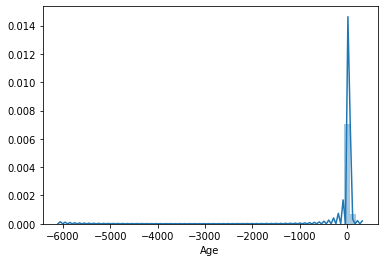

In [15]:
sns.distplot(all_data['Age'])

In [16]:
# Assigning all ages less than zero to 0
all_data.loc[all_data['Age'] < 0 , 'Age']=0
all_data.loc[all_data['Age'] > 120 , 'Age']=120

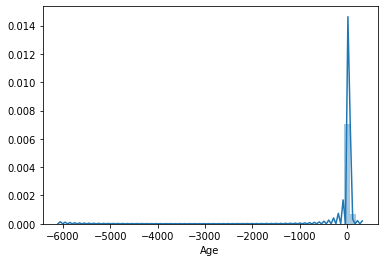

In [16]:
sns.distplot(all_data['Age'])

In [ ]:
a

In [17]:
all_data.describe()

,Age,No_Pol
count,13281.000000,13281.000000
mean,42.375574,1.302763
std,93.170951,0.723195
min,-6099.000000,1.000000
25%,35.000000,1.000000
50%,41.000000,1.000000
75%,50.000000,1.000000
max,320.000000,10.000000


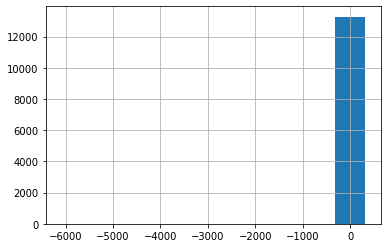

In [18]:
all_data['Age'].hist()

In [19]:
stat_policy_product = Train.groupby('ProductName')['No_Pol'].agg(['mean','std'])

In [22]:
avg_num_policy_product = stat_policy_product['mean'].to_dict()
std_policy_product = stat_policy_product['std'].to_dict()

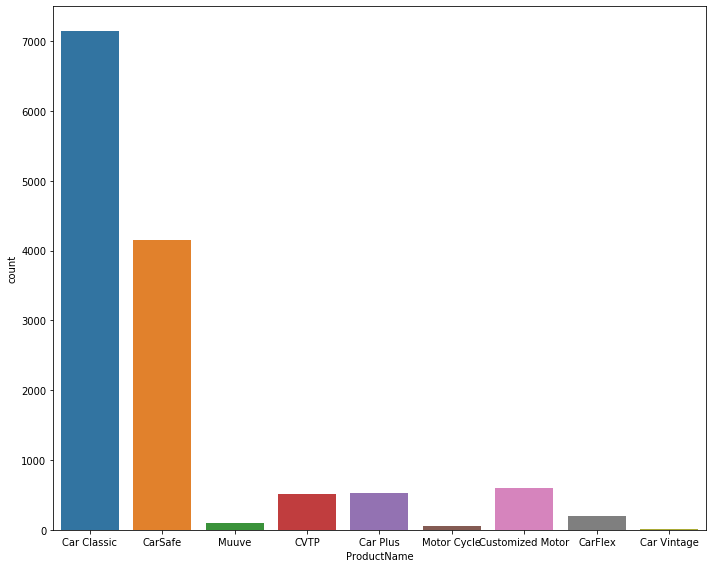

In [23]:
plt.figure(figsize=(10,8))
sns.countplot(all_data['ProductName'], orient='h')
plt.tight_layout()

In [24]:
descr

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


In [20]:
print(set(all_data['First Transaction Date'] == all_data['Policy Start Date']))


dropable = ['First Transaction Date']

{True}


In [29]:
def to_datetime(df,cols):
    X = df.copy()
    for col in cols:
        X[col] = pd.to_datetime(X[col])
    return X
all_data = to_datetime(all_data,date_feat)

In [30]:
def extract_date_info(df,cols,):
    X = df.copy()
    for feat in cols:
        X[f'{feat}_year'] = X[feat].dt.year
        X[f'{feat}_day'] = X[feat].dt.day_name()
        X[f'{feat}_date'] = X[feat].dt.day
        X[f'{feat}_month'] = X[feat].dt.month
        X[f'{feat}_quarter'] = X[feat].dt.quarter
        
        #X[f'{feat}_is_month_end'] = X[feat].dt.is_month_end
    X.drop(columns=cols,axis=1, inplace=True)
    
    return X
    

In [31]:
date_feat[:-1]

['Policy Start Date', 'Policy End Date']

In [32]:
df = extract_date_info(all_data,date_feat[:-1]).drop('First Transaction Date', axis=1)

In [33]:
#df['num_product_policy_std'] = all_data['ProductName'].map(std_policy_product)
#df['avg_policy_product'] = all_data['ProductName'].map(avg_num_policy_product)

In [34]:
df

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Policy Start Date_year,Policy Start Date_day,Policy Start Date_date,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_day,Policy End Date_date,Policy End Date_month,Policy End Date_quarter
0,ID_0040R73,Male,30,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,2010,Friday,14,5,2,2011,Friday,13,5,2
1,ID_0046BNK,Female,79,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,2010,Monday,29,11,4,2011,Monday,28,11,4
2,ID_005QMC3,Male,43,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,2010,Sunday,21,3,1,2011,Sunday,20,3,1
3,ID_0079OHW,Male,2,1,NaN,NaN,NaN,NaN,NaN,CarSafe,2010,Saturday,21,8,3,2011,Saturday,20,8,3
4,ID_00BRP63,Entity,20,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,2010,Sunday,29,8,3,2010,Friday,31,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13276,ID_ZTTHC5X,Male,67,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,2010,Sunday,5,12,4,2011,Sunday,4,12,4
13277,ID_ZUJAFUP,Male,43,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,2010,Thursday,14,1,1,2011,Thursday,13,1,1
13278,ID_ZWHCTUM,Male,30,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,2010,Monday,26,7,3,2011,Monday,25,7,3
13279,ID_ZWQRL8L,Male,44,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,2010,Tuesday,16,2,1,2011,Tuesday,15,2,1


In [35]:
df[cat_feats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  13281 non-null  object
 1   Gender              12881 non-null  object
 2   Car_Category        9171 non-null   object
 3   Subject_Car_Colour  5622 non-null   object
 4   Subject_Car_Make    10557 non-null  object
 5   LGA_Name            6149 non-null   object
 6   State               6137 non-null   object
 7   ProductName         13281 non-null  object
dtypes: object(8)
memory usage: 830.2+ KB


In [36]:
missing_like = ['Subject_Car_Colour','LGA_Name','State']

In [37]:
df['LGA_Name'].value_counts()

Victoria Island    1284
Ikeja               438
Surulere            306
Abuja Municipal     257
Lagos Mainland      245
                   ... 
Ikwerre               1
Owerri North          1
Garki                 1
Orsu                  1
Oshimili North        1
Name: LGA_Name, Length: 270, dtype: int64

In [38]:
year_feat = ['Policy Start Date_year','Policy End Date_year']

In [39]:
df[year_feat]

,Policy Start Date_year,Policy End Date_year
0,2010,2011
1,2010,2011
2,2010,2011
3,2010,2011
4,2010,2010
...,...,...
13276,2010,2011
13277,2010,2011
13278,2010,2011
13279,2010,2011


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         13281 non-null  object
 1   Gender                     12881 non-null  object
 2   Age                        13281 non-null  int64 
 3   No_Pol                     13281 non-null  int64 
 4   Car_Category               9171 non-null   object
 5   Subject_Car_Colour         5622 non-null   object
 6   Subject_Car_Make           10557 non-null  object
 7   LGA_Name                   6149 non-null   object
 8   State                      6137 non-null   object
 9   ProductName                13281 non-null  object
 10  Policy Start Date_year     13281 non-null  int64 
 11  Policy Start Date_day      13281 non-null  object
 12  Policy Start Date_date     13281 non-null  int64 
 13  Policy Start Date_month    13281 non-null  int64 
 14  Policy

In [41]:
df['Tenure_of_Policy'] = df['Policy End Date_year'] - df['Policy Start Date_year']

#df.drop(year_feat, inplace=True, axis=1)

In [42]:
#Get the new dataset
train = df[:ntrain].drop('ID', axis=1)
test = df[ntrain:].drop('ID', axis=1)

In [43]:
cat = train.select_dtypes(include=['object']).columns
num = train.drop(cat,axis=1).columns

In [44]:
on_check = ['Policy Start Date_quarter', 'Policy End Date_quarter',
       'First Transaction Date_quarter']

In [45]:
impute = SimpleImputer(strategy='most_frequent')
tr_train = pd.DataFrame(impute.fit_transform(train.drop(missing_like,axis=1)), columns=train.drop(missing_like,axis=1).columns)
tr_test = pd.DataFrame(impute.transform(test.drop(missing_like,axis=1)), columns=test.drop(missing_like,axis=1).columns)

In [46]:
tr_train[num] = tr_train[num].astype(int)
tr_test[num] = tr_test[num].astype(int)

In [47]:
tr_train = pd.concat([tr_train,Train[missing_like]], axis=1).fillna('Not_Given')
tr_test = pd.concat([tr_test,Test[missing_like]], axis=1).fillna('Not_Given')

In [48]:
ntrain = tr_train.shape[0]
ntest = tr_test.shape[0]

data = pd.concat((tr_train, tr_test)).reset_index(drop=True)
print("all_data size is : {}".format(data.shape)) 

all_data size is : (13281, 20)


In [49]:
tr_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Gender                     12079 non-null  object
 1   Age                        12079 non-null  int32 
 2   No_Pol                     12079 non-null  int32 
 3   Car_Category               12079 non-null  object
 4   Subject_Car_Make           12079 non-null  object
 5   ProductName                12079 non-null  object
 6   Policy Start Date_year     12079 non-null  int32 
 7   Policy Start Date_day      12079 non-null  object
 8   Policy Start Date_date     12079 non-null  int32 
 9   Policy Start Date_month    12079 non-null  int32 
 10  Policy Start Date_quarter  12079 non-null  int32 
 11  Policy End Date_year       12079 non-null  int32 
 12  Policy End Date_day        12079 non-null  object
 13  Policy End Date_date       12079 non-null  int32 
 14  Policy

In [50]:
tr_train['Subject_Car_Colour'].value_counts()

Not_Given         6962
Black             1880
Silver             554
Grey               514
As Attached        498
Blue               361
White              293
Red                251
Green              233
Gold               173
Ash                133
Wine                89
Brown               58
Cream                8
Yellow               8
Dark Gray            5
White & Blue         5
Orange               5
Purple               4
Red & White          4
D. Red               3
Blue & Red           3
Light Green          3
B.Silver             2
Dark Grey            2
Red & Black          2
White & Red          2
Black & Orange       2
Gray & Gray          2
Dark Blue            2
Gray & Silver        2
Black & White        2
Light Blue           1
D. Gold              1
Burgundy             1
White & Yellow       1
Red & Blue           1
Blue Sky             1
Champagne            1
Dark Red             1
Beige Mitalic        1
Yellow & White       1
Blue&White&Red       1
Dark Green 

In [51]:


other_car_colour = tr_train['Subject_Car_Colour'].value_counts()[11:].index
def categorise_car_colour(val):
    if val in other_car_colour:
        return 'Other'
    else:
        return val
data['Subject_Car_Colour'] = data.Subject_Car_Colour.apply(categorise_car_colour)

#tr_train['Subject_Car_Colour'] = tr_train.Subject_Car_Colour.apply(categorise_car_colour)
#tr_test['Subject_Car_Colour'] = tr_test.Subject_Car_Colour.apply(categorise_car_colour)

In [52]:
other_car_make = data['Subject_Car_Make'].value_counts()[12:].index
def categorise_car_make(val):
    if val in other_car_make:
        return 'Other'
    else:
        return val
    
data['Subject_Car_Make'] = data.Subject_Car_Make.apply(categorise_car_make)
#tr_train['Subject_Car_Make'] = tr_train.Subject_Car_Make.apply(categorise_car_make)
#tr_test['Subject_Car_Make'] = tr_test.Subject_Car_Make.apply(categorise_car_make)

In [53]:
def gender(val):
    if val not in ['Male','Female']:
        return 'Other'
    else:
        return val
data['Gender'] = data.Gender.apply(gender)
#tr_train['Gender'] = tr_train.Gender.apply(gender)
#tr_test['Gender'] = tr_test.Gender.apply(gender)

In [54]:
other_category = list(data['Car_Category'].value_counts()[3:].index)
def categorise_car(val):
    if val in other_category:
        return 'Other'
    else:
        return val
data['Car_Category'] = data.Car_Category.apply(categorise_car)

In [55]:

from sklearn.preprocessing import LabelEncoder
encode_lg = LabelEncoder()
encode_st = LabelEncoder()

data['LGA_Code'] = encode_lg.fit_transform(data['LGA_Name'])
data['State_Code'] = encode_st.fit_transform(data['State'])



In [56]:
data.loc[data['State_Code'] == 82, 'State_Code'] = -1
data.loc[data['LGA_Code'] == 183, 'LGA_Code'] = -1

In [57]:
one_hot_cols = ['ProductName','Gender','Car_Category','Subject_Car_Make','Subject_Car_Colour','Policy Start Date_day',
                'Policy End Date_day']


print(one_hot_cols)

['ProductName', 'Gender', 'Car_Category', 'Subject_Car_Make', 'Subject_Car_Colour', 'Policy Start Date_day', 'Policy End Date_day']


In [58]:
dummied_data = pd.get_dummies(data.drop(['State','LGA_Name'],axis=1), 
                               columns= one_hot_cols, 
                               drop_first=True)

In [59]:
#Get the new dataset
df_train = dummied_data[:ntrain]
df_test = dummied_data[ntrain:]

In [60]:
df_train

,Age,No_Pol,Policy Start Date_year,Policy Start Date_date,Policy Start Date_month,Policy Start Date_quarter,Policy End Date_year,Policy End Date_date,Policy End Date_month,Policy End Date_quarter,...,Policy Start Date_day_Sunday,Policy Start Date_day_Thursday,Policy Start Date_day_Tuesday,Policy Start Date_day_Wednesday,Policy End Date_day_Monday,Policy End Date_day_Saturday,Policy End Date_day_Sunday,Policy End Date_day_Thursday,Policy End Date_day_Tuesday,Policy End Date_day_Wednesday
0,30,1,2010,14,5,2,2011,13,5,2,...,0,0,0,0,0,0,0,0,0,0
1,79,1,2010,29,11,4,2011,28,11,4,...,0,0,0,0,1,0,0,0,0,0
2,43,1,2010,21,3,1,2011,20,3,1,...,1,0,0,0,0,0,1,0,0,0
3,2,1,2010,21,8,3,2011,20,8,3,...,0,0,0,0,0,1,0,0,0,0
4,20,3,2010,29,8,3,2010,31,12,4,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074,30,1,2010,25,5,2,2011,24,5,2,...,0,0,1,0,0,0,0,0,1,0
12075,59,1,2010,3,10,4,2011,2,10,4,...,1,0,0,0,0,0,1,0,0,0
12076,34,1,2010,10,10,4,2011,8,10,4,...,1,0,0,0,0,1,0,0,0,0
12077,120,2,2010,27,2,1,2011,26,2,1,...,0,0,0,0,0,1,0,0,0,0


In [61]:
X_train, X_test,y_train, y_test = train_test_split(df_train,Train['target'],
                                                   test_size=0.2, stratify=Train['target'], random_state=42)

In [84]:
from sklearn.utils import resample
class Oversample:
    
    def __init__(self,minor,target_col, resample_len=None ):
        '''Returns a dataframe and target column (Series) with the minority class being oversampled '''
        self.hold = 0
        self.minor = minor
        self.reclaim = 0
        self.sample_len = resample_len
        self.target_col = target_col
        
    def fit_transform(self, X, y=None):
        
        self.hold = X.copy()
        self.hold[self.target_col] = y.values
        self.reclaim = self.hold[self.hold[self.target_col] == self.minor]
        major_df = self.hold[self.hold[self.target_col] != self.minor]
        
        if self.sample_len == None:
            self.sample_len = len(major_df)
            
        resampled = resample(self.reclaim, n_samples=self.sample_len, replace=True, random_state=42)
        df = pd.concat([major_df,resampled])
        
        return df.drop(self.target_col, axis= 1), df.target
        
        

In [81]:
def get_mode(arr_preds):
    from scipy import stats
    res = stats.mode(arr_preds)[0].reshape(-1,)
    return res


def Train_Evaluate(models,train_data,target, val_metric=f1_score, test_data=None,params=None):
    
    train_score_sheet = {}
    val_score_sheet = {}
    named_models = {}
    names = []
    preds_val = {}
    predictions = {}
    idx = 0
    
        
    for name, model in models.items():
        named_models[name] = model
        
        if params != None:
            if name in params.keys():
                pass
        
        print('====={}===============Training: {}=========================='.format(idx+1,name))
        if type(model) == type(lightgbm.LGBMClassifier()):
            predictions[name], preds_val[name],train_score_sheet[name], val_score_sheet[name], named = LGBMTrain(model,train_data,target,test_data,name)
            names.append(named)
        
        elif type(model) == type(xgb.XGBClassifier()):
            predictions[name],preds_val[name],train_score_sheet[name], val_score_sheet[name], named = XGBTrain(model,train_data,target, test_data, name)
        
        elif type(model) == type(catboost.CatBoostClassifier()):
            
            predictions[name],preds_val[name],train_score_sheet[name], val_score_sheet[name], named  = CatBoostTrain(model,train_data,target,test_data, name)
            
        else:
            
            mean_train_scores = []
            mean_val_scores = []
            val_pred = np.zeros(train_data.shape[0])
            test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
            impute = SimpleImputer(fill_value=99999)
            train_set = pd.DataFrame(impute.fit_transform(train_data), columns=train_data.columns)
            test_set =  pd.DataFrame(impute.transform(test_data), columns=test_data.columns)
            
            for index, (train_index, val_index) in enumerate(skf.split(train_set,target)):

                print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
                temp_x_train , x_test = train_set.iloc[train_index], train_set.iloc[val_index]
                temp_y_train, y_test = target.iloc[train_index], target.iloc[val_index]
                
                # oversampling train set
                x_train, y_train = Oversample(1,target_col='target').fit_transform(temp_x_train,temp_y_train)

                model.fit(x_train,y_train)

                train_predict = model.predict(x_train)
                preds = model.predict(x_test)
                val_pred[val_index] = preds
                test_pred[index] = model.predict(test_set)

                mean_train_scores.append(f1_score(y_train,train_predict))
                mean_val_scores.append(f1_score(y_test,preds))
                print('\nValidation Score :::> ', val_metric(y_test,preds))
                print('\nTraining Score   :::> ', val_metric(y_train, train_predict))
            test_predictions = get_mode(test_pred)
            predictions[name] = test_predictions
            preds_val[name] = val_pred[:]
            train_score_sheet[name] = np.mean(mean_train_scores)
            val_score_sheet[name] = np.mean(mean_val_scores)
            print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
            print('\nAverage Validation Score ::>', np.mean(mean_val_scores))            
            
                      
        idx+=1
            
    return train_score_sheet, val_score_sheet, named_models,preds_val, predictions

In [82]:
lgbm = lightgbm.LGBMClassifier()

#X_train, X_test, y_train, y_test = train_test_split(Train, TRAIN['default_status'], stratify= TRAIN['default_status'], 
#                    random_state=55)


def LGBMTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        temp_x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        temp_y_train, y_test = target.iloc[train_index], target.iloc[val_index]
        
        # oversampling train_set
        x_train, y_train = Oversample(1,'target').fit_transform(temp_x_train,temp_y_train)
        
        model.fit(x_train,y_train, eval_set=(x_test,y_test), eval_metric = 'error', verbose= 50)

        train_predict = model.predict(x_train, num_iterations=model.best_iteration_)
        lgb_preds = model.predict(x_test, num_iterations = model.best_iteration_)
        val_pred[val_index] = lgb_preds
        test_pred [index] = model.predict(test_data, num_iterations = model.best_iteration_)

        mean_train_scores.append(f1_score(y_train,train_predict))
        mean_val_scores.append(f1_score(y_test,lgb_preds))
        print('\nValidation Score :::> ', f1_score(y_test,lgb_preds))
        print('\nTraining Score   :::> ', f1_score(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    test_predictions = get_mode(test_pred)
    
    return test_predictions,val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name



def XGBTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        temp_x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        temp_y_train, y_test = target.iloc[train_index], target.iloc[val_index]
        
        # oversampling train_set
        x_train, y_train = Oversample(1,'target').fit_transform(temp_x_train,temp_y_train)

        model.fit(x_train,y_train, eval_set=[(x_test,y_test)], eval_metric = 'error', verbose= 50, early_stopping_rounds=200)

        train_predict = model.predict(x_train, ntree_limit = model.get_booster().best_ntree_limit)
        xgb_preds = model.predict(x_test, ntree_limit = model.get_booster().best_ntree_limit)
        val_pred[val_index] = xgb_preds
        test_pred [index] = model.predict(test_data, ntree_limit = model.get_booster().best_ntree_limit)

        mean_train_scores.append(f1_score(y_train,train_predict))
        mean_val_scores.append(f1_score(y_test,xgb_preds))
        print('\nValidation Score :::> ', f1_score(y_test,xgb_preds))
        print('\nTraining Score   :::> ', f1_score(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    test_predictions = get_mode(test_pred)
    
    return test_predictions,val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name


def CatBoostTrain(model,train_data,target,test_data, name):
    mean_train_scores = []
    mean_val_scores = []
    val_pred = np.zeros(train_data.shape[0])
    test_pred = np.zeros((skf.n_splits,test_data.shape[0]))
    for index, (train_index, val_index) in enumerate(skf.split(train_data,target)):

        print('\n==========================>**Fold {}**<================================\n\n'.format(index+1))
        print('Now using catboos')
        temp_x_train , x_test = train_data.iloc[train_index], train_data.iloc[val_index]
        temp_y_train, y_test = target.iloc[train_index], target.iloc[val_index]
        
        # oversampling train_set
        x_train, y_train = Oversample(1,'target').fit_transform(temp_x_train,temp_y_train)
        
        model.fit(x_train,y_train, eval_set=(x_test,y_test), verbose= 50)

        train_predict = model.predict_proba(x_train)[:,1]
        cat_preds = model.predict_proba(x_test)[:,1]
        val_pred[val_index] = cat_preds
        test_pred += model.predict_proba(test_data)[:,1]

        mean_train_scores.append(roc_auc_score(y_train,train_predict))
        mean_val_scores.append(roc_auc_score(y_test,cat_preds))
        print('\nValidation Score :::> ', roc_auc_score(y_test,cat_preds))
        print('\nTraining Score   :::> ', roc_auc_score(y_train, train_predict))


    print('\nAverage Training Score   ::>', np.mean(mean_train_scores))
    print('\nAverage Validation Score ::>', np.mean(mean_val_scores))
    
    
    return test_pred,val_pred, np.mean(mean_train_scores), np.mean(mean_val_scores), name


In [64]:
y_train.value_counts(normalize=True)

0    0.879541
1    0.120459
Name: target, dtype: float64

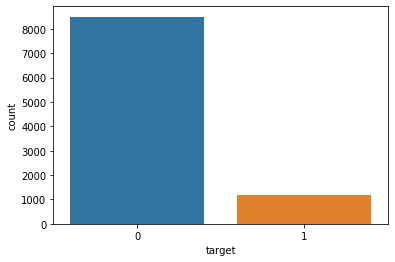

In [65]:
sns.countplot(y_train)

In [85]:
#oversample = Oversample(minor = 1, target_col='target')
train, Target = df_train, Train['target']
test = df_test.copy()

In [86]:
Train.shape, Target.shape

((12079, 14), (12079,))

In [87]:
train.shape, Target.shape

((12079, 62), (12079,))

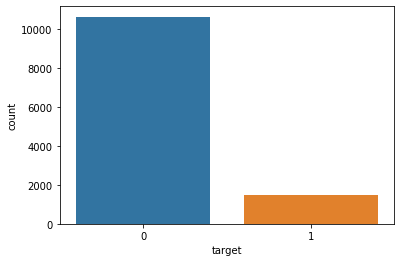

In [88]:
sns.countplot(Target)

In [89]:
set(train.columns == df_train.columns)

{True}

In [90]:
train.shape,test.shape

((12079, 62), (1202, 62))

In [91]:
set(train.columns == test.columns)

{True}

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [93]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=10, shuffle=True, random_state=45)

In [94]:
from sklearn.ensemble import BaggingClassifier, StackingClassifier

In [95]:
stack = StackingClassifier([('RFC',RandomForestClassifier(random_state=43, n_estimators=200)),
                            ('EXT',ExtraTreesClassifier(random_state=45, n_estimators=300))])

In [97]:
models = {'EXT':ExtraTreesClassifier(random_state=45, n_estimators=300),
          'KNN': KNeighborsClassifier(3),
          'tree': DecisionTreeClassifier(),
          'GB':GradientBoostingClassifier(random_state=42),
           'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200),
            'XGB': xgb.XGBClassifier(random_state=45, n_estimators=500),
         'LGBM': lightgbm.LGBMClassifier(random_state=45, n_estimators=500),
         }

model = {'RandomForest': RandomForestClassifier(random_state=42, n_estimators=200)}
train_scores, val_scores, named_models,preds_val, preds = Train_Evaluate(model,train, Target,
                                                              test_data=test)

=====1===============Training: RandomForest==========================

==========================>**Fold 1**<================================



Validation Score :::>  0.3440860215053763

Training Score   :::>  0.9731376631290306

==========================>**Fold 2**<================================



Validation Score :::>  0.27450980392156865

Training Score   :::>  0.9731300667924335

==========================>**Fold 3**<================================



Validation Score :::>  0.28363636363636363

Training Score   :::>  0.974080097580809

==========================>**Fold 4**<================================



Validation Score :::>  0.2773722627737226

Training Score   :::>  0.9739599226935205

==========================>**Fold 5**<================================



Validation Score :::>  0.2689075630252101

Training Score   :::>  0.9729316409236887

==========================>**Fold 6**<================================



Validation Score :::>  0.3041825095057034

Training Sc

In [99]:
val_scores

{'RandomForest': 0.29216406740904466}

In [77]:
val_scores

{'EXT': 0.9637787468753792}

In [85]:
def Stack(**kwargs):
    stacked = {name : preds for name, preds in kwargs.items()}
    df_stacked = pd.DataFrame(stacked)
    
    return df_stacked
        
    

In [86]:
predictions = preds
stacked_train = Stack(EXT = preds_val['EXT'], tree = preds_val['tree'],KNN =  preds_val['KNN'],
                      RFC = preds_val['RandomForest'],XGB = preds_val['XGB'], LGBM=preds_val['LGBM'], STK =preds_val['STK'])

stacked_test = Stack(EXT = predictions['EXT'], tree = predictions['tree'], KNN = predictions['KNN'],
                        RFC = predictions['RandomForest'],XGB = predictions['XGB'], LGBM = predictions['LGBM'],
                     STK = predictions['STK'])

In [ ]:
predictions = preds
stacked_train_1 = Stack(EXT = preds_val['EXT'], tree = preds_val['tree'],KNN =  preds_val['KNN'],
                      RFC = preds_val['RandomForest'],XGB = preds_val['XGB'], LGBM=preds_val['LGBM'],
                     LGBM_1 = preds_val['LGBM_1'],EXT_1 = preds_val['EXT_1'], GB = preds_val['GB'],STK = preds_val['STK'])

stacked_test_1 = Stack(EXT = predictions['EXT'], tree = predictions['tree'], KNN = predictions['KNN'],
                        RFC = predictions['RandomForest'],XGB = predictions['XGB'], LGBM = predictions['LGBM'],
                    LGBM_1 = predictions['LGBM_1'],EXT_1 = predictions['EXT_1'],GB = predictions['GB'],
                    STK = predictions['STK'])

In [88]:
meta_estimators = {'LGR':LogisticRegression(random_state=45),
                  'XGB':xgb.XGBClassifier(random_state=45), 'RFC': RandomForestClassifier(random_state=45),
                  'STK':stack}

In [ ]:
stk_train_scores, stk_val_scores, stk_named_models,stk_preds_val, stk_predictions = Train_Evaluate(meta_estimators,
                                                                stacked_train, Target, test_data=stacked_test)

In [ ]:
stk_train_scores, stk_val_scores, stk_named_models,stk_preds_val, stk_predictions = Train_Evaluate(meta_estimators,
                                                                stacked_train_1, Target, test_data=stacked_test_1)

In [189]:
stk_val_scores

{'LGR': 0.964965003788018,
 'XGB': 0.9656330759958746,
 'RFC': 0.9656330759958746}

In [93]:
stk_val_scores

{'LGR': 0.9676005245552348,
 'XGB': 0.968052627643789,
 'RFC': 0.9679684798668795,
 'STK': 0.9680550792056712}

In [96]:
val_scores

{'EXT': 0.9637787468753792,
 'KNN': 0.9066291734931979,
 'tree': 0.9273230223900122,
 'GB': 0.779687884014168,
 'LGBM_1': 0.8123414410061454,
 'EXT_1': 0.7340722560258363,
 'RandomForest': 0.9608010310658628,
 'XGB': 0.946581661317131,
 'LGBM': 0.9307105518663381,
 'STK': 0.9674250121324889}

In [97]:
stk_predictions.keys()

dict_keys(['LGR', 'XGB', 'RFC', 'STK'])

In [301]:
preds_array = np.array([stk_preds_val['LGR'],
                        stk_preds_val['RFC'],stk_preds_val['XGB']])

blends = get_mode(preds_array)

In [302]:
f1_score(Target,blends)

0.9668341708542714

In [303]:
blend_df = np.array([stk_predictions['LGR'],stk_predictions['RFC'],stk_predictions['XGB']])
blended =  get_mode(blend_df)

In [94]:


submit = Test[['ID']]
for name, pred in preds.items():
    if name in ['STK','EXT','RandomForest','XGB']:
        submit['target'] = pred
        submit.to_csv(f'SUBMIT_{name}_NEWEST.csv', index=False)

In [99]:


submit = Test[['ID']]

for name, pred in stk_predictions.items():
    
    submit['target'] = pred
    submit.to_csv(f'./Stack_preds/MY_NEWEST_SUBMISSION_{name}_STACK.csv', index=False)

In [196]:
submit = Test[['ID']]
submit['target'] = blended
submit.to_csv('Submit_stack_blend_newwest.csv', index=False)

In [98]:
submit = Test[['ID']]
submit['target'] = preds['RandomForest']

submit.to_csv('submit_rfc1.csv', index=False)

In [ ]:
Training: GradientBoosting

In [238]:
submit.head()

,ID,target
0,009D84L,1
1,01DO2EQ,1
2,01QM0NU,0
3,024NJLZ,0
4,02BYET3,1
